In [1]:
# TODO: compare means and run some statistical test.
# TODO: training time as a function of model size?

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext heat

In [3]:
from importlib import reload 
import os
from validation import inference_scoring
reload(inference_scoring)
from validation.inference_scoring import model_dirs_to_edge_vectors_list, \
    model_dirs_to_timeseries_vectors, model_dirs_to_boolean_function_vectors, \
    aggregate_classification_metric, model_dirs_to_time_taken_vector, sparse_accuracy_score, \
    model_dirs_to_network_sizes
from sklearn.metrics import accuracy_score, roc_auc_score
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import itertools

# Initial learning

In [4]:
inference_results_parent_dir = os.path.join("..", "inferred_models", "initial_learning")
inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(inference_results_parent_dir) if 
                           f.is_dir()}
model_names = [f.name for f in os.scandir(next(iter(inference_variant_paths.values())))
                   if f.is_dir()]

In [61]:
variant_timeseries_train_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_train.npy"))
                                  for model_name in model_names]
                           for variant_name, path in inference_variant_paths.items()}
variant_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                           for variant_name, path in inference_variant_paths.items()}

variant_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in inference_variant_paths.items()}

network_sizes_nodes = model_dirs_to_network_sizes(next(iter(inference_variant_paths.values())), with_edges=False) 
network_sizes_all = model_dirs_to_network_sizes(next(iter(inference_variant_paths.values())), with_edges=True) 

variant_edge_scores = dict()
for v, p in inference_variant_paths.items():
    variant_edge_scores[v] = [float(np.load(os.path.join(
        p, name, "edge_accuracy_score.npy"))) for name in model_names]

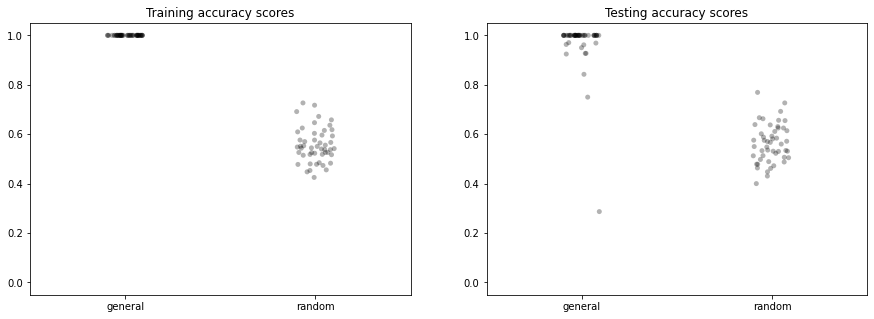

In [6]:
metrics = {'Training accuracy scores': variant_timeseries_train_scores,
           'Testing accuracy scores': variant_timeseries_test_scores}
plt.rc('figure', figsize=(15.0, 5.0))
fig, axs = plt.subplots(1, 2)
for idx, (title, scoring_dict) in enumerate(metrics.items()):
    ax = axs[idx]
    variants, values = zip(*list(scoring_dict.items()))
#     sns.boxplot(ax=ax, data=values)
#     sns.violinplot(ax=ax, inner="quartile", data=values)
#     sns.swarmplot(ax=ax, data=values, alpha=0.3, color='black')
    sns.stripplot(ax=ax, data=values, alpha=0.3, color='black')
    ax.set_xticklabels(variants, rotation=0);
    ax.title.set_text(title)
    ax.set_ylim(-0.05, 1.05)
plt.show()
print("\n\n")

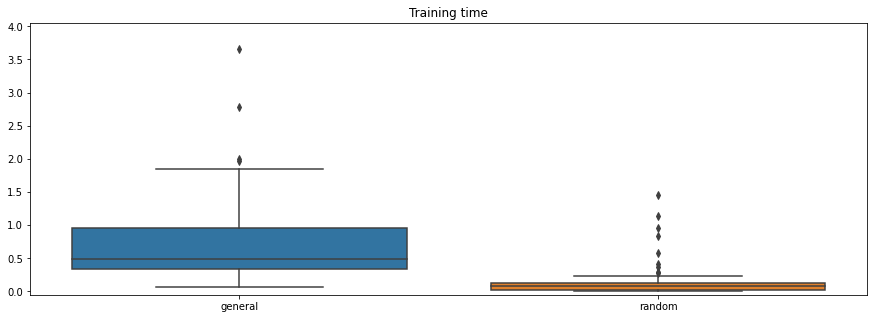

In [7]:
plt.rc('figure', figsize=(15.0, 5.0))
fig, ax = plt.subplots(1, 1)
variants, values = zip(*list(variant_timings.items()))
sns.boxplot(ax=ax, data=values)
# sns.violinplot(ax=ax, inner="quartile", data=values)
# sns.swarmplot(ax=ax, data=values, alpha=0.3, color='black')
# sns.stripplot(ax=ax, data=values, alpha=0.3, color='black')
ax.set_xticklabels(variants, rotation=0);
ax.title.set_text("Training time")
ax.set_ylim(-0.05, 4.05)
plt.show()
print("\n\n")

[5, 15, 18, 22, 16, 20, 68, 18, 25, 26, 28, 51, 15, 18, 26, 18, 18, 9, 26, 14, 25, 53, 32, 38, 15, 14, 38, 68, 23, 25, 67, 15, 22, 13, 53, 40, 28, 33, 11, 26, 16, 33, 20, 34, 15, 53, 18, 17, 44, 11, 28, 34, 22, 18, 20, 12, 33, 11, 26, 13, 51, 40, 16, 41, 40, 67, 44, 28, 16, 34, 68, 12, 62, 26, 22, 53, 51, 19, 25, 32, 33, 19, 62, 16, 16, 23, 25, 16, 25, 25, 41, 41, 24, 16, 17, 28, 67, 5, 14, 16, 33, 20, 33, 16, 62, 53, 17, 9, 23, 22, 15, 13, 18, 24, 15, 24, 32, 15, 25, 13, 18, 10, 13, 28, 20, 16, 13, 23, 10, 15, 25, 12, 9, 53, 38, 19, 20, 19, 23, 19, 16, 5, 19, 44, 10, 23, 22]
[5, 15, 18, 22, 16, 20, 68, 18, 25, 26, 28, 51, 15, 18, 26, 18, 18, 9, 26, 14, 25, 53, 32, 38, 15, 14, 38, 68, 23, 25, 67, 15, 22, 13, 53, 40, 28, 33, 11, 26, 16, 33, 20, 34, 15, 53, 18, 17, 44, 11, 28, 34, 22, 18, 20, 12, 33, 11, 26, 13, 51, 40, 16, 41, 40, 67, 44, 28, 16, 34, 68, 12, 62, 26, 22, 53, 51, 19, 25, 32, 33, 19, 62, 16, 16, 23, 25, 16, 25, 25, 41, 41, 24, 16, 17, 28, 67, 5, 14, 16, 33, 20, 33, 16, 62,

IndexError: index 2 is out of bounds for axis 0 with size 2

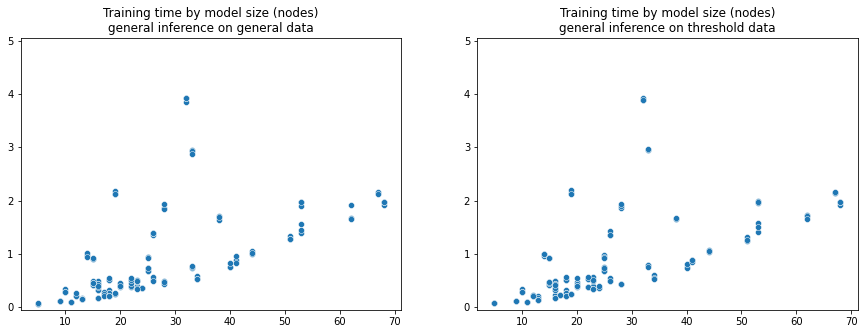

In [62]:
ordered_model_names = list(model_names)
plt.rc('figure', figsize=(15.0, 5.0))
fig, axs = plt.subplots(1, 2)
for index, variant in enumerate(variant_timings.keys()):
    ax = axs[index]
    timings = variant_timings[variant]
    network_sizes = network_sizes_nodes
    sns.scatterplot(x=network_sizes, y=timings, ax=ax)
#     ax.set_xticklabels(network_sizes, rotation=0);
    ax.title.set_text("Training time by model size (nodes)\n{}".format(variant))
    ax.set_ylim(-0.05, 5.05)
plt.show()
print("\n\n")

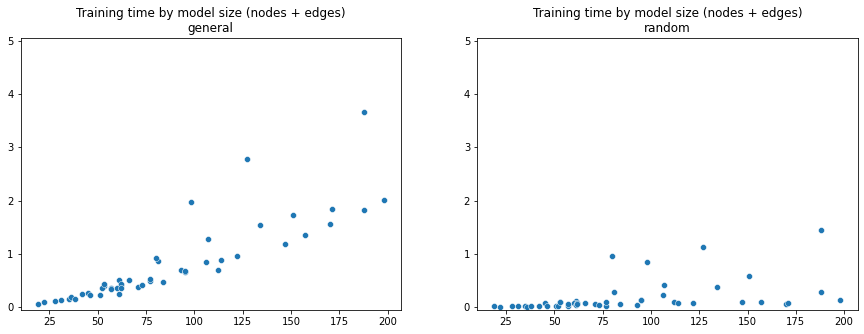

In [9]:
ordered_model_names = list(model_names)
plt.rc('figure', figsize=(15.0, 5.0))
fig, axs = plt.subplots(1, 2)
for index, variant in enumerate(variant_timings.keys()):
    ax = axs[index]
    timings = variant_timings[variant]
    network_sizes = network_sizes_all
    sns.scatterplot(x=network_sizes, y=timings, ax=ax)
#     ax.set_xticklabels(network_sizes, rotation=0);
    ax.title.set_text("Training time by model size (nodes + edges)\n{}".format(variant))
    ax.set_ylim(-0.05, 5.05)
plt.show()
print("\n\n")

# Noise Robustness

In [10]:
inference_results_parent_dir = os.path.join("..", "inferred_models", "noise")
state_inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(os.path.join(inference_results_parent_dir, 
                                                        "state")) if f.is_dir()}
scaffold_add_inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(os.path.join(inference_results_parent_dir, 
                                                        "scaffold_add")) if f.is_dir()}
scaffold_remove_inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(os.path.join(inference_results_parent_dir, 
                                                        "scaffold_remove")) if f.is_dir()}

In [11]:
state_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                           for variant_name, path in state_inference_variant_paths.items()}
scaffold_add_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_add_inference_variant_paths.items()}
scaffold_remove_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_remove_inference_variant_paths.items()}


state_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in state_inference_variant_paths.items()}
scaffold_add_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in scaffold_add_inference_variant_paths.items()}
scaffold_remove_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in scaffold_remove_inference_variant_paths.items()}

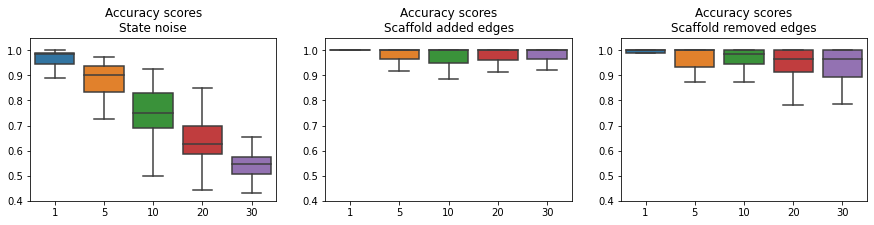

In [59]:
metrics = {'Accuracy scores\nState noise': state_timeseries_test_scores,
           'Accuracy scores\nScaffold added edges': scaffold_add_timeseries_test_scores,
           'Accuracy scores\nScaffold removed edges': scaffold_remove_timeseries_test_scores}
plt.rc('figure', figsize=(15.0, 3))
fig, axs = plt.subplots(1, 3)
for idx, (title, scoring_dict) in enumerate(metrics.items()):
    ax = axs[idx]
    variants, values = zip(*list(sorted(scoring_dict.items(), key=lambda tup: int(tup[0]))))
    sns.boxplot(ax=ax, data=values, showfliers=False)
#     sns.violinplot(ax=ax, inner="quartile", data=values)
#     sns.swarmplot(ax=ax, data=values, alpha=0.3, color='black')
#     sns.stripplot(ax=ax, data=values, alpha=0.3, color='black')
    ax.set_xticklabels(variants, rotation=0);
    ax.title.set_text(title)
    ax.set_ylim(0.4, 1.05)
plt.show()
print("\n\n")

# TODO: replace with lines?

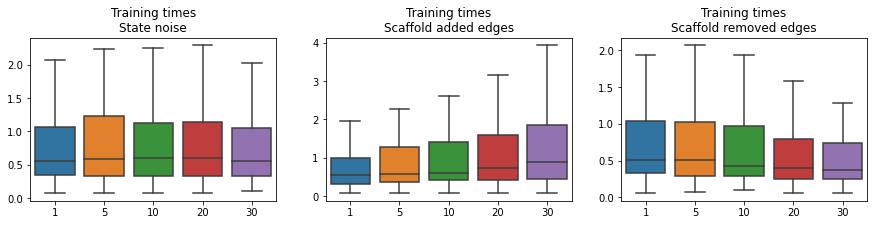

In [36]:
metrics = {'Training times\nState noise': state_timings,
           'Training times\nScaffold added edges': scaffold_add_timings,
           'Training times\nScaffold removed edges': scaffold_remove_timings}
plt.rc('figure', figsize=(15.0, 3))
fig, axs = plt.subplots(1, 3)
for idx, (title, scoring_dict) in enumerate(metrics.items()):
    ax = axs[idx]
    variants, values = zip(*list(sorted(scoring_dict.items(), key=lambda tup: int(tup[0]))))
    sns.boxplot(ax=ax, data=values, showfliers=False)
#     sns.violinplot(ax=ax, inner="quartile", data=values)
#     sns.swarmplot(ax=ax, data=values, alpha=0.3, color='black')
#     sns.stripplot(ax=ax, data=values, alpha=0.3, color='black')
    ax.set_xticklabels(variants, rotation=0);
    ax.title.set_text(title)
#     ax.set_ylim(-0.05, 1.05)
plt.show()
print("\n\n")

# Data Requirements

In [14]:
inference_results_parent_dir = os.path.join("..", "inferred_models", "data_requirement")
matrices_inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(os.path.join(inference_results_parent_dir, 
                                                        "variable_matrices")) if f.is_dir()}
timepoints_inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(os.path.join(inference_results_parent_dir, 
                                                        "variable_timepoints")) if f.is_dir()}

In [15]:
matrices_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                           for variant_name, p ath in matrices_inference_variant_paths.items()}
timepoints_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                           for variant_name, path in timepoints_inference_variant_paths.items()}


matrices_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in matrices_inference_variant_paths.items()}

timepoints_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in timepoints_inference_variant_paths.items()}

variant_edge_scores = dict()
for v, p in inference_variant_paths.items():
    model_names = {f.name for f in os.scandir(p) if f.is_dir()}
    variant_edge_scores[v] = [float(np.load(os.path.join(
        p, name, "edge_accuracy_score.npy"))) for name in model_names]

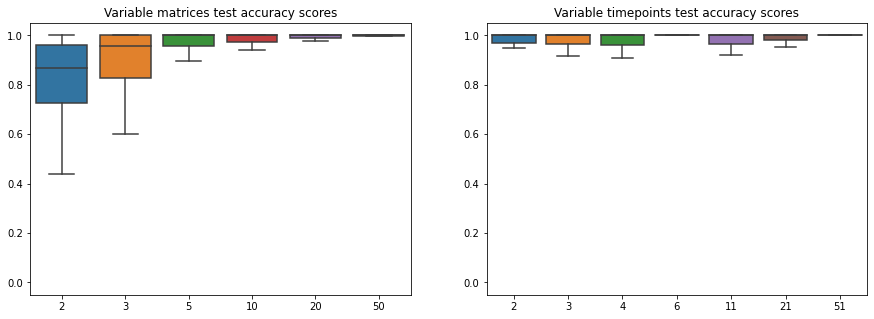

In [53]:
metrics = {'Variable matrices test accuracy scores': matrices_timeseries_test_scores,
           'Variable timepoints test accuracy scores': timepoints_timeseries_test_scores}
plt.rc('figure', figsize=(15.0, 5.0))
fig, axs = plt.subplots(1, 2)
for idx, (title, scoring_dict) in enumerate(metrics.items()):
    ax = axs[idx]
    variants, values = zip(*list(sorted(scoring_dict.items(), key=lambda tup: int(tup[0]))))
    sns.boxplot(ax=ax, data=values, showfliers=False)
#     sns.violinplot(ax=ax, inner="quartile", data=values)
#     sns.swarmplot(ax=ax, data=values, alpha=0.3, color='black')
#     sns.stripplot(ax=ax, data=values, alpha=0.3, color='black')
    ax.set_xticklabels(variants, rotation=0);
    ax.title.set_text(title)
    ax.set_ylim(-0.05, 1.05)
plt.show()
print("\n\n")

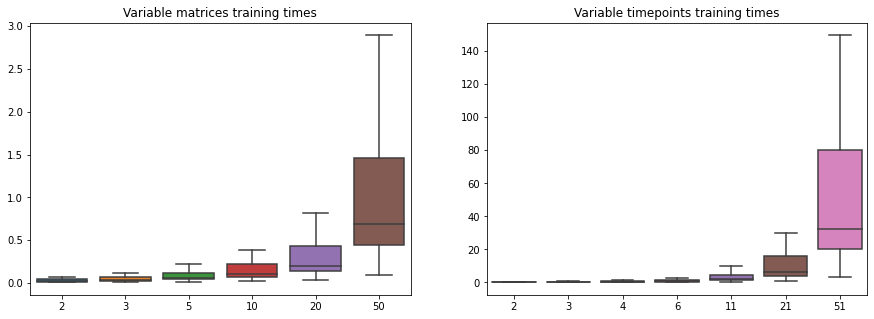

In [55]:
metrics = {'Variable matrices training times': matrices_timings,
           'Variable timepoints training times': timepoints_timings}
plt.rc('figure', figsize=(15.0, 5.0))
fig, axs = plt.subplots(1, 2)
for idx, (title, scoring_dict) in enumerate(metrics.items()):
    ax = axs[idx]
    variants, values = zip(*list(sorted(scoring_dict.items(), key=lambda tup: int(tup[0]))))
    sns.boxplot(ax=ax, data=values, showfliers=False)
#     sns.violinplot(ax=ax, inner="quartile", data=values)
#     sns.swarmplot(ax=ax, data=values, alpha=0.3, color='black')
#     sns.stripplot(ax=ax, data=values, alpha=0.3, color='black')
    ax.set_xticklabels(variants, rotation=0);
    ax.title.set_text(title)
#     ax.set_ylim(-0.05, 50.05)
plt.show()
print("\n\n")

# Model Restriction

In [63]:
inference_results_parent_dir = os.path.join("..", "inferred_models", "model_restriction")
inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(inference_results_parent_dir) if f.is_dir()}

In [64]:
variant_timeseries_train_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_train.npy"))
                                  for model_name in model_names]
                        for variant_name, path in inference_variant_paths.items()}
variant_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                        for variant_name, path in inference_variant_paths.items()}

variant_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in inference_variant_paths.items()}

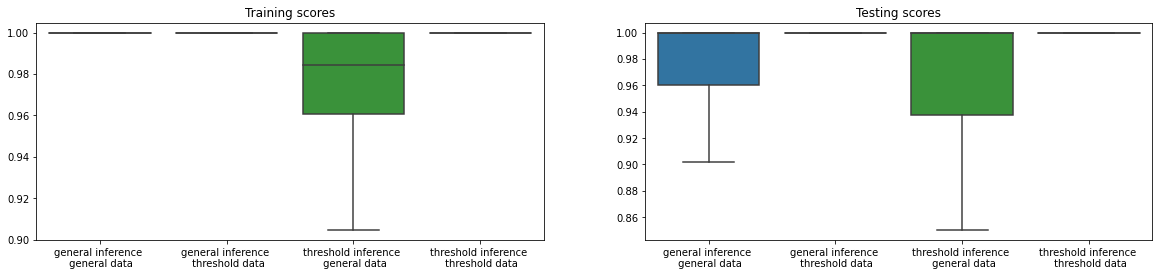

In [69]:
metrics = {'Training scores': variant_timeseries_train_scores,
           'Testing scores': variant_timeseries_test_scores}
plt.rc('figure', figsize=(20.0, 4))
fig, axs = plt.subplots(1, 2)
for idx, (title, scoring_dict) in enumerate(metrics.items()):
    ax = axs[idx]
    variants, values = zip(*list(sorted(scoring_dict.items(), key=lambda tup: tup[0])))
    sns.boxplot(ax=ax, data=values, showfliers=False)
#     sns.violinplot(ax=ax, inner="quartile", data=values)
#     sns.swarmplot(ax=ax, data=values, alpha=0.3, color='black')
#     sns.stripplot(ax=ax, data=values, alpha=0.2, color='black')
    ax.set_xticklabels(["{}\n{}".format(*v.split("on")) for v in variants], rotation=0, wrap=True);
    ax.title.set_text(title)
#     ax.set_ylim(0.5, 1.05)
plt.show()
print("\n\n")

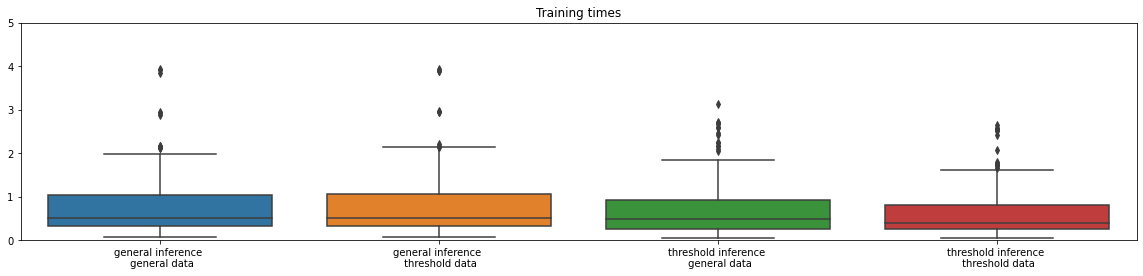

In [27]:
metrics = {'Training times': variant_timings}
plt.rc('figure', figsize=(20.0, 4))
fig, axs = plt.subplots(1, 1)
for idx, (title, scoring_dict) in enumerate(metrics.items()):
    ax = axs
    variants, values = zip(*list(sorted(scoring_dict.items(), key=lambda tup: tup[0])))
    sns.boxplot(ax=ax, data=values)
#     sns.violinplot(ax=ax, inner="quartile", data=values)
#     sns.swarmplot(ax=ax, data=values, alpha=0.3, color='black')
#     sns.stripplot(ax=ax, data=values, alpha=0.2, color='black')
    ax.set_xticklabels(["{}\n{}".format(*v.split("on")) for v in variants], rotation=0, wrap=True);
    ax.title.set_text(title)
    ax.set_ylim(0.0, 5)
plt.show()
print("\n\n")

# Unknown Topology

In [28]:
inference_results_parent_dir = os.path.join("..", "inferred_models", "unknown_topology")
scaffold_add_general_inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(os.path.join(inference_results_parent_dir, 
                           "scaffold_add", "general")) if f.is_dir()}
scaffold_add_threshold_known_inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(os.path.join(inference_results_parent_dir, 
                           "scaffold_add", "threshold_known")) if f.is_dir()}
scaffold_add_threshold_unknown_inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(os.path.join(inference_results_parent_dir, 
                           "scaffold_add", "threshold_unknown")) if f.is_dir()}

scaffold_remove_general_inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(os.path.join(inference_results_parent_dir, 
                           "scaffold_remove", "general")) if f.is_dir()}
scaffold_remove_threshold_known_inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(os.path.join(inference_results_parent_dir, 
                           "scaffold_remove", "threshold_known")) if f.is_dir()}
scaffold_remove_threshold_unknown_inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(os.path.join(inference_results_parent_dir, 
                           "scaffold_remove", "threshold_unknown")) if f.is_dir()}


In [29]:
scaffold_add_general_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_add_general_inference_variant_paths.items()}
scaffold_add_threshold_known_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_add_threshold_known_inference_variant_paths.items()}
scaffold_add_threshold_unknown_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_add_threshold_unknown_inference_variant_paths.items()}
scaffold_add_variant_test_scores = {'general': scaffold_add_general_timeseries_test_scores,
                                    'threshold_known': scaffold_add_threshold_known_timeseries_test_scores,
                                    'threshold_unknown': scaffold_add_threshold_unknown_timeseries_test_scores}

scaffold_remove_general_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_remove_general_inference_variant_paths.items()}
scaffold_remove_threshold_known_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_remove_threshold_known_inference_variant_paths.items()}
scaffold_remove_threshold_unknown_timeseries_test_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_test.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_remove_threshold_unknown_inference_variant_paths.items()}
scaffold_remove_variant_test_scores = {'general': scaffold_remove_general_timeseries_test_scores,
                                    'threshold_known': scaffold_remove_threshold_known_timeseries_test_scores,
                                    'threshold_unknown': scaffold_remove_threshold_unknown_timeseries_test_scores}


scaffold_add_general_timeseries_train_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_train.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_add_general_inference_variant_paths.items()}
scaffold_add_threshold_known_timeseries_train_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_train.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_add_threshold_known_inference_variant_paths.items()}
scaffold_add_threshold_unknown_timeseries_train_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_train.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_add_threshold_unknown_inference_variant_paths.items()}
scaffold_add_variant_train_scores = {'general': scaffold_add_general_timeseries_train_scores,
                                    'threshold_known': scaffold_add_threshold_known_timeseries_train_scores,
                                    'threshold_unknown': scaffold_add_threshold_unknown_timeseries_train_scores}

scaffold_remove_general_timeseries_train_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_train.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_remove_general_inference_variant_paths.items()}
scaffold_remove_threshold_known_timeseries_train_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_train.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_remove_threshold_known_inference_variant_paths.items()}
scaffold_remove_threshold_unknown_timeseries_train_scores = {variant_name: [np.load(os.path.join(path, model_name, 
                                                       "timeseries_accuracy_score_train.npy"))
                                  for model_name in model_names]
                           for variant_name, path in scaffold_remove_threshold_unknown_inference_variant_paths.items()}
scaffold_remove_variant_train_scores = {'general': scaffold_remove_general_timeseries_train_scores,
                                    'threshold_known': scaffold_remove_threshold_known_timeseries_train_scores,
                                    'threshold_unknown': scaffold_remove_threshold_unknown_timeseries_train_scores}



scaffold_add_general_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in scaffold_add_general_inference_variant_paths.items()}
scaffold_add_threshold_known_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in scaffold_add_threshold_known_inference_variant_paths.items()}
scaffold_add_threshold_unknown_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in scaffold_add_threshold_unknown_inference_variant_paths.items()}
scaffold_add_variant_timings = {'general': scaffold_add_general_timings,
                                    'threshold_known': scaffold_add_threshold_known_timings,
                                    'threshold_unknown': scaffold_add_threshold_unknown_timings}


scaffold_remove_general_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in scaffold_remove_general_inference_variant_paths.items()}
scaffold_remove_threshold_known_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in scaffold_remove_threshold_known_inference_variant_paths.items()}
scaffold_remove_threshold_unknown_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in scaffold_remove_threshold_unknown_inference_variant_paths.items()}
scaffold_remove_variant_timings = {'general': scaffold_remove_general_timings,
                                    'threshold_known': scaffold_remove_threshold_known_timings,
                                    'threshold_unknown': scaffold_remove_threshold_unknown_timings}


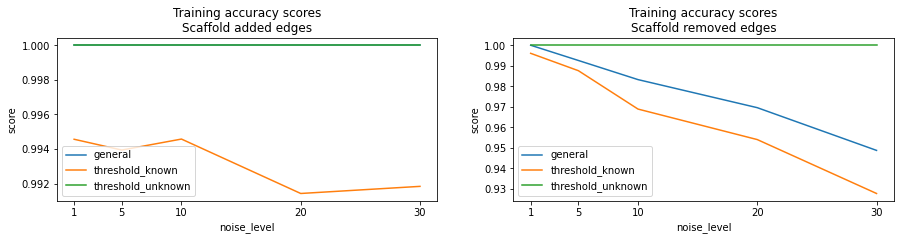

In [71]:
metrics = {'Training accuracy scores\nScaffold added edges': scaffold_add_variant_train_scores,
           'Training accuracy scores\nScaffold removed edges': scaffold_remove_variant_train_scores}
plt.rc('figure', figsize=(15.0, 3))
fig, axs = plt.subplots(1, 2)
for idx, (title, scoring_dict) in enumerate(metrics.items()):
    ax = axs[idx]
    noise_levels = sorted([int(x) for x in next(iter(scoring_dict.values())).keys()])
    score_lists = []
    for variant, variant_scores in scoring_dict.items():
        # for some reasons the scores are saved with values as zero-dimensional numpy arrays.
        level_score_pairs = itertools.chain(*[[(int(level), float(score)) for score in scores] 
                            for level, scores in variant_scores.items()])
        df = pd.DataFrame(level_score_pairs)
        df.columns = ['noise_level', 'score']
        sns.lineplot(data=df, ax=ax, x='noise_level', y='score', err_style=None) #'band')
    ax.title.set_text(title)
    ax.set_xticks(noise_levels)
    ax.legend(scoring_dict.keys(), loc="lower left")
plt.show()
print("\n\n")

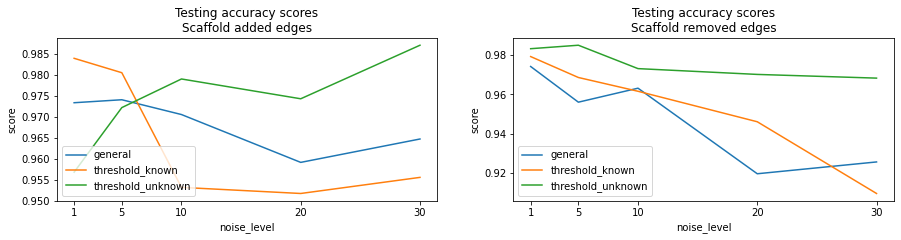

In [72]:
metrics = {'Testing accuracy scores\nScaffold added edges': scaffold_add_variant_test_scores,
           'Testing accuracy scores\nScaffold removed edges': scaffold_remove_variant_test_scores}
plt.rc('figure', figsize=(15.0, 3))
fig, axs = plt.subplots(1, 2)
for idx, (title, scoring_dict) in enumerate(metrics.items()):
    ax = axs[idx]
    noise_levels = sorted([int(x) for x in next(iter(scoring_dict.values())).keys()])
    score_lists = []
    for variant, variant_scores in scoring_dict.items():
        # for some reasons the scores are saved with values as zero-dimensional numpy arrays.
        level_score_pairs = itertools.chain(*[[(int(level), float(score)) for score in scores] 
                            for level, scores in variant_scores.items()])
        df = pd.DataFrame(level_score_pairs)
        df.columns = ['noise_level', 'score']
        sns.lineplot(data=df, ax=ax, x='noise_level', y='score', err_style=None) #err_style='band')
    ax.title.set_text(title)
    ax.set_xticks(noise_levels)
    ax.legend(scoring_dict.keys(), loc="lower left")
plt.show()
print("\n\n")

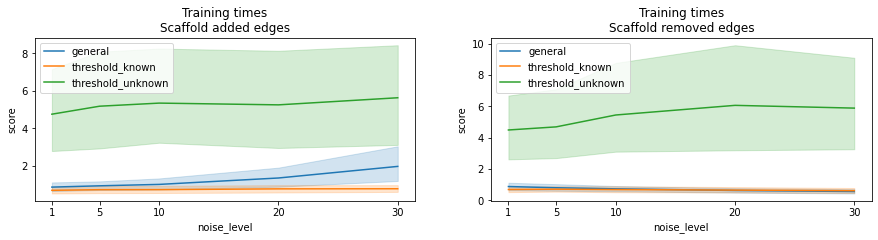

In [32]:
metrics = {'Training times\nScaffold added edges': scaffold_add_variant_timings,
           'Training times\nScaffold removed edges': scaffold_remove_variant_timings}
plt.rc('figure', figsize=(15.0, 3))
fig, axs = plt.subplots(1, 2)
for idx, (title, scoring_dict) in enumerate(metrics.items()):
    ax = axs[idx]
    noise_levels = sorted([int(x) for x in next(iter(scoring_dict.values())).keys()])
    score_lists = []
    for variant, variant_scores in scoring_dict.items():
        # for some reasons the scores are saved with values as zero-dimensional numpy arrays.
        level_score_pairs = itertools.chain(*[[(int(level), float(score)) for score in scores] 
                            for level, scores in variant_scores.items()])
        df = pd.DataFrame(level_score_pairs)
        df.columns = ['noise_level', 'score']
        sns.lineplot(data=df, ax=ax, x='noise_level', y='score', err_style='band')
    ax.title.set_text(title)
    ax.set_xticks(noise_levels)
    ax.legend(scoring_dict.keys(), loc="upper left")
plt.show()
print("\n\n")